Data loaded successfully.
FFT Analysis saved to 'full_analysis_fft.png'
Wavelet Plot saved.


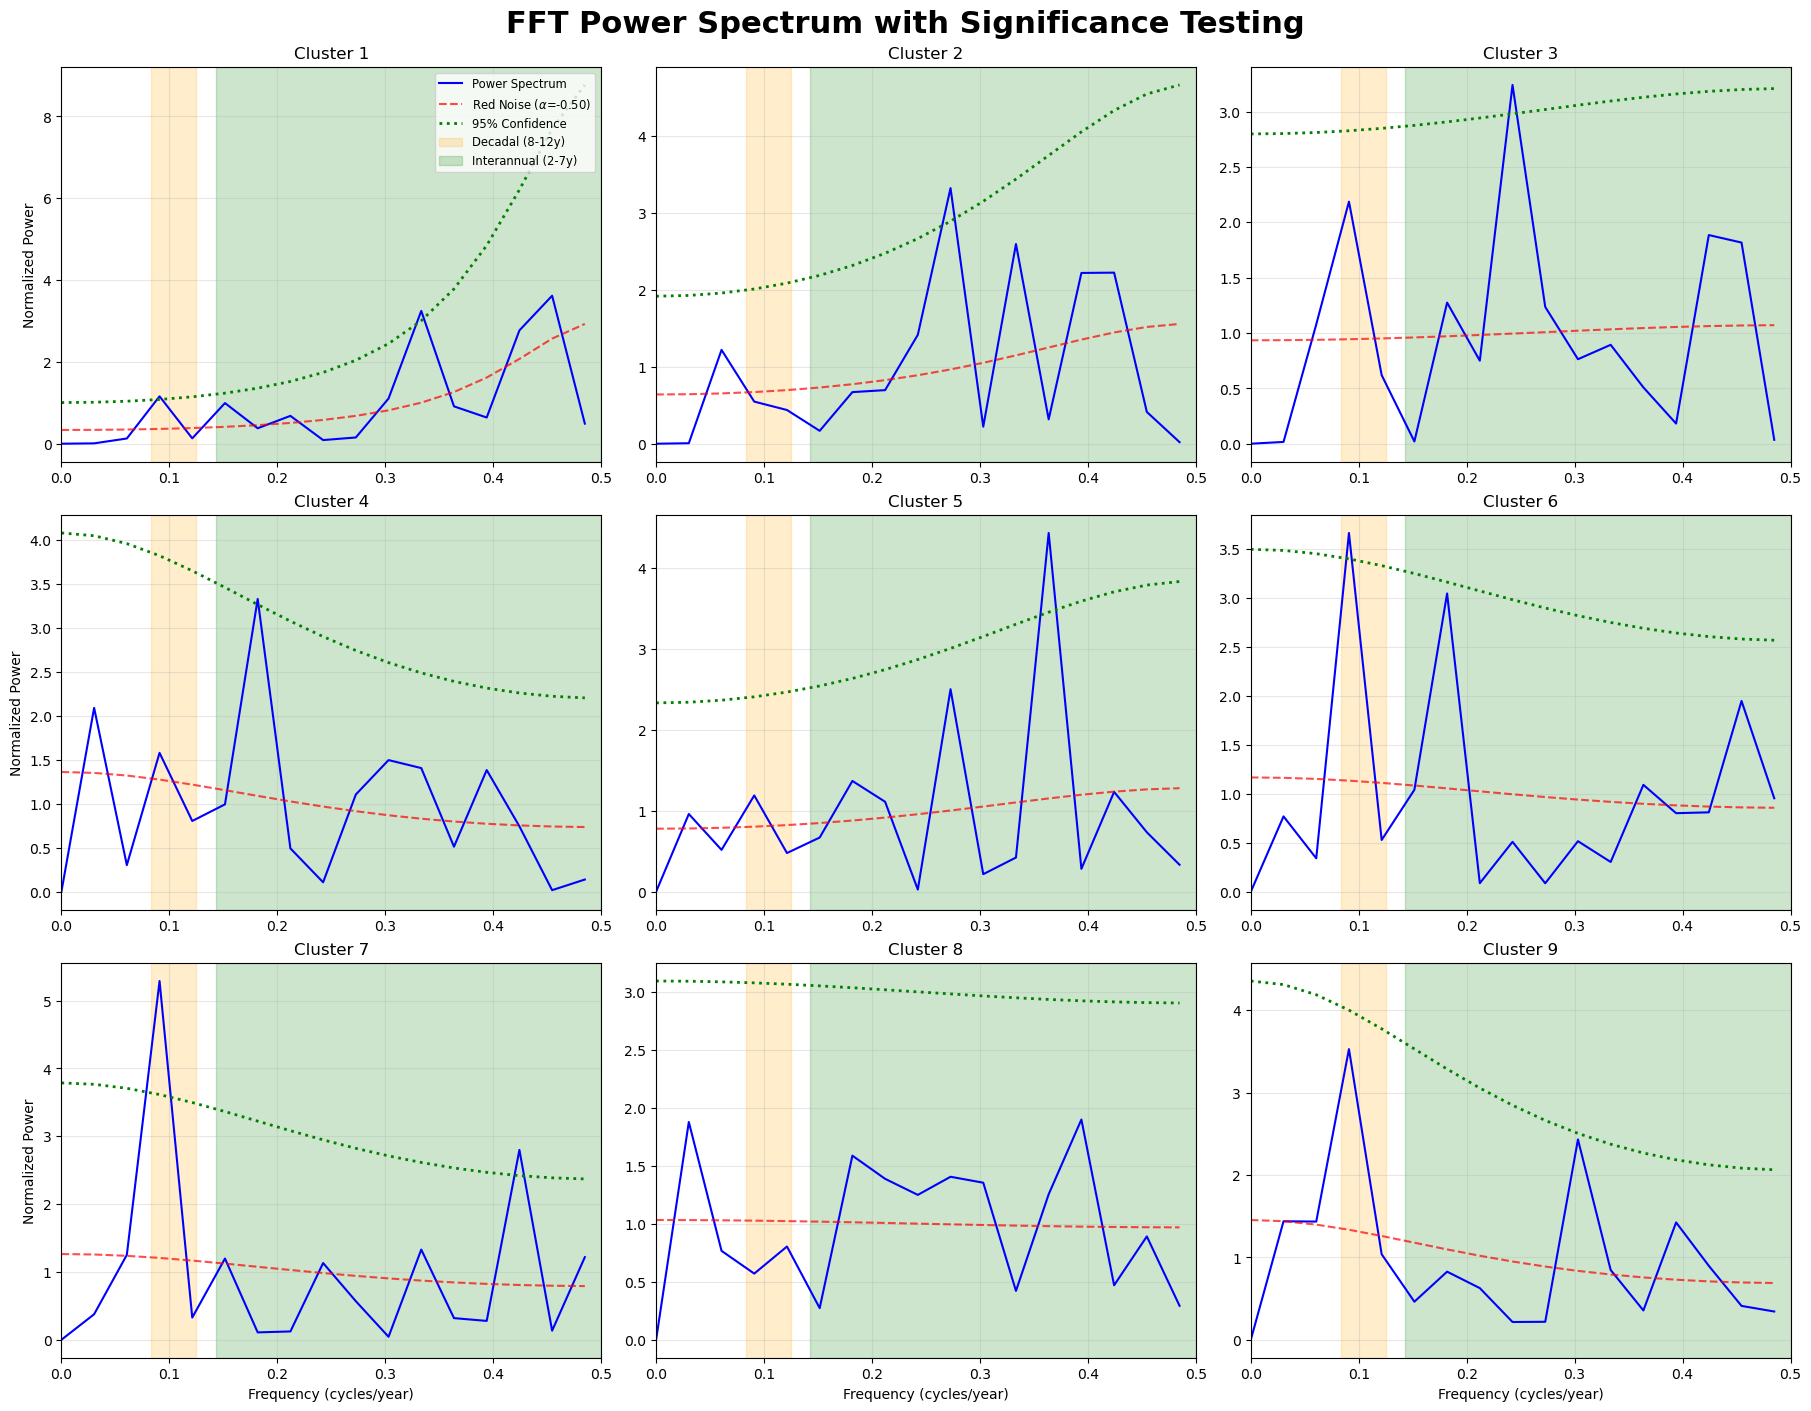

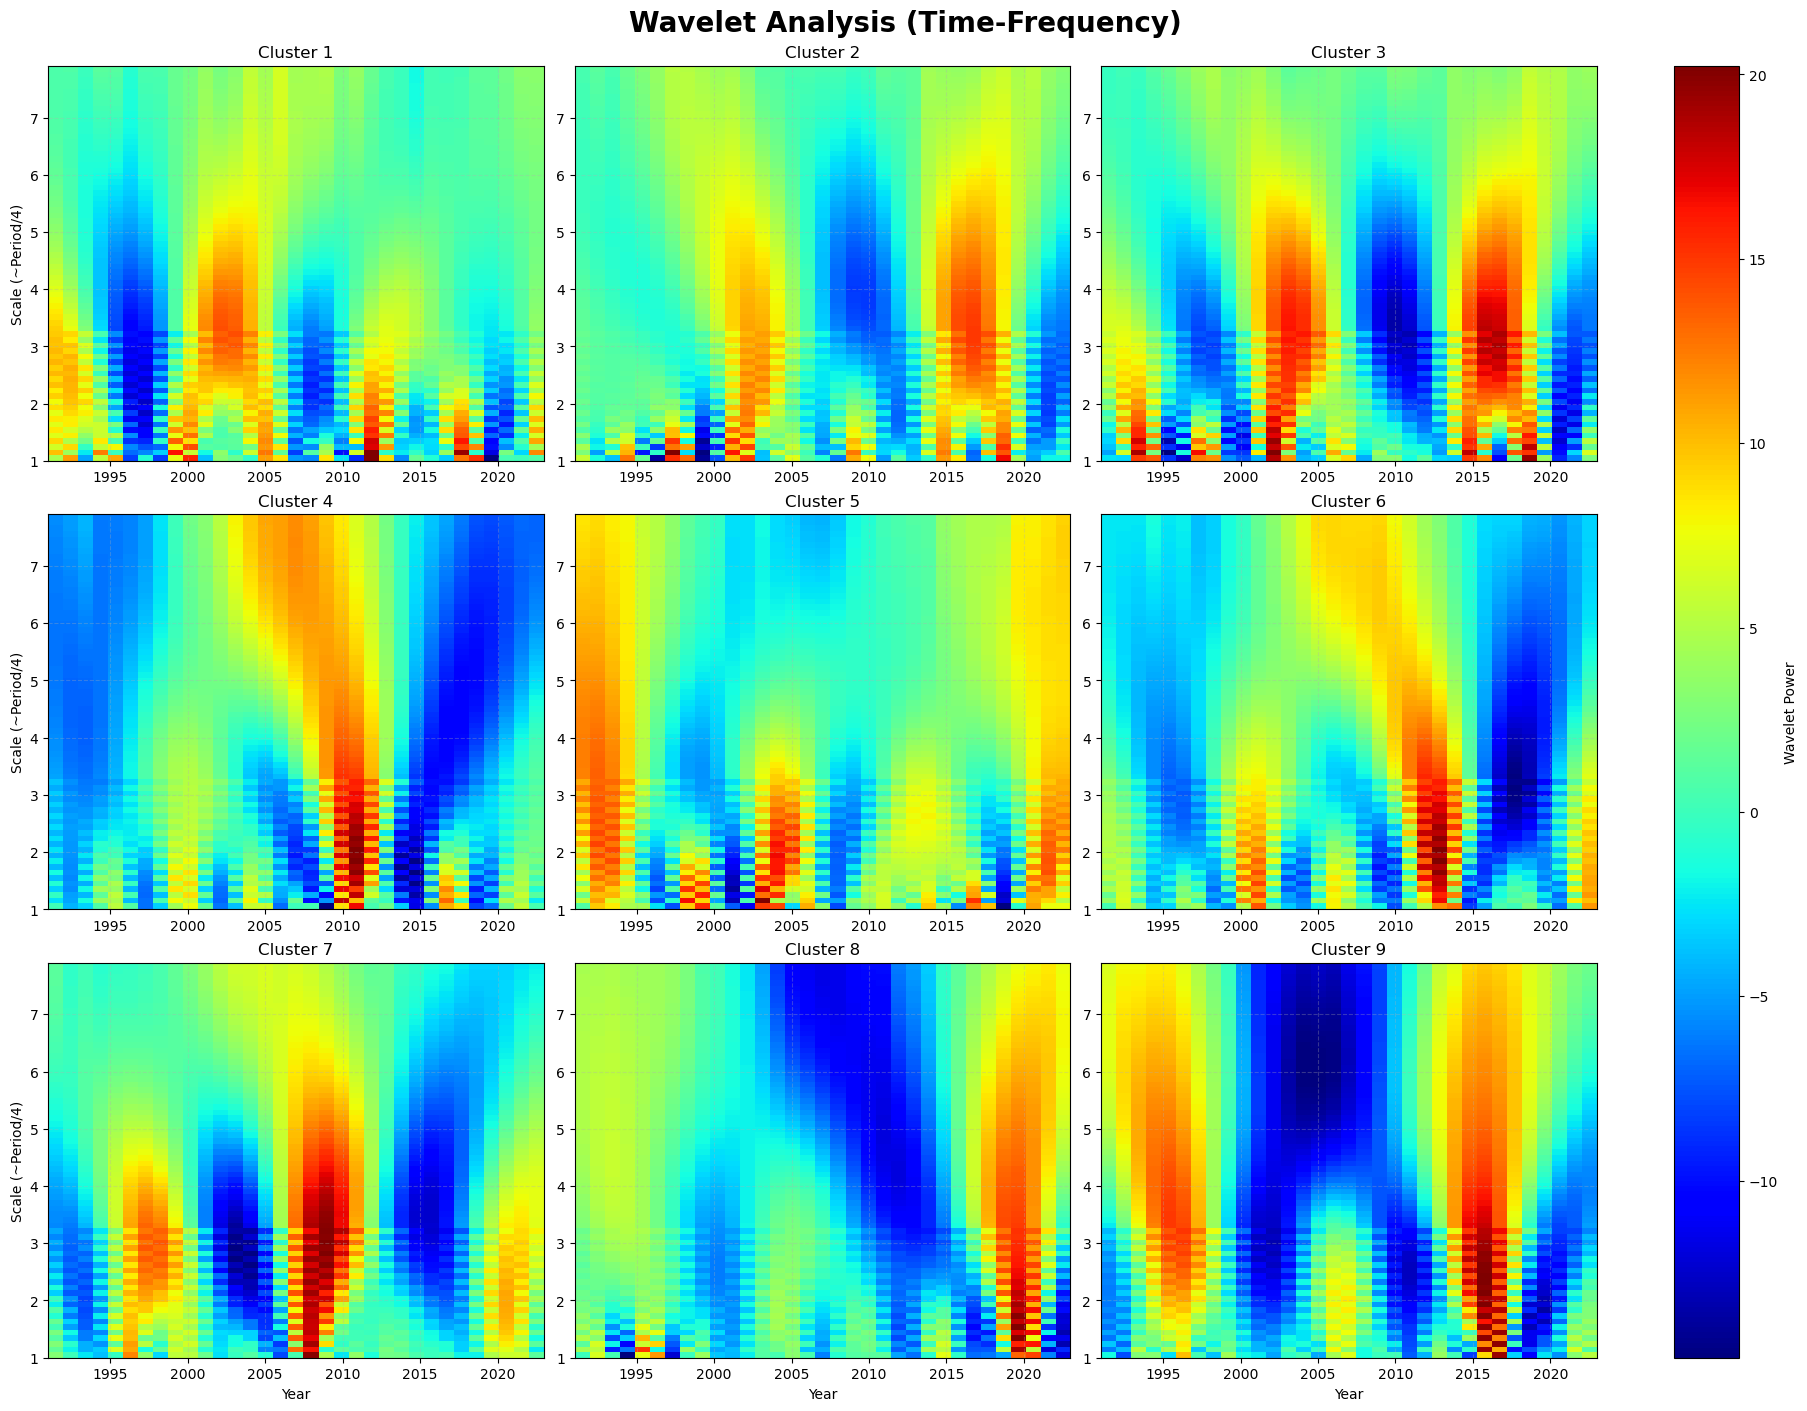

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.fft
import scipy.signal
import scipy.stats as stats

# --- 0. ROBUST CWT DEFINITION ---
# If scipy.signal.cwt is missing, we define a manual version so the code runs.
if hasattr(scipy.signal, "cwt"):
    my_cwt = scipy.signal.cwt
    print("Using scipy.signal.cwt")
else:
    print("Warning: scipy.signal.cwt not found. Using manual fallback implementation.")

    def my_cwt(data, wavelet, widths):
        output = np.zeros((len(widths), len(data)))
        for i, width in enumerate(widths):
            # Typical length for Ricker wavelet is 10 * width
            points = int(min(10 * width, len(data)))
            # Generate wavelet
            w = wavelet(points, width)
            # Convolve
            output[i, :] = scipy.signal.fftconvolve(data, w, mode="same")
        return output


# Ensure Ricker wavelet exists (it usually does, but just in case)
if not hasattr(scipy.signal, "ricker"):
    # Manual Ricker (Mexican Hat) definition
    def ricker(points, a):
        A = 2 / (np.sqrt(3 * a) * (np.pi**0.25))
        wsq = a**2
        vec = np.arange(0, points) - (points - 1.0) / 2
        xsq = vec**2
        mod = 1 - xsq / wsq
        gauss = np.exp(-xsq / (2 * wsq))
        return A * mod * gauss

    my_ricker = ricker
else:
    my_ricker = scipy.signal.ricker

# ==========================================
# 1. LOAD DATA & SETUP
# ==========================================
# Load the dataset
try:
    counts = pd.read_csv("../Data/u850_cluster_counts.csv")
    print("Data loaded successfully.")
except FileNotFoundError:
    # Generate dummy data if file not found (for testing purposes)
    print(
        "File not found. Please ensure 'uwind_cluster_counts.csv' is in the directory."
    )
    raise

# Extract variables
years = counts["year"].values
data_matrix = counts.iloc[:, 1:].values  # Columns 1-9 are clusters
N = len(years)
T = 1.0  # Sampling interval (1 year)

# ==========================================
# 2. FFT ANALYSIS (With Red Noise Testing)
# ==========================================
fig_fft, axs_fft = plt.subplots(3, 3, figsize=(18, 14), constrained_layout=True)

# Define Frequency Bands of Interest
decadal_range = [1 / 12, 1 / 8]  # 8-12 years (Low Freq)
interannual_range = [1 / 7, 1 / 2]  # 2-7 years  (High Freq)

for i, ax in enumerate(axs_fft.flatten()):
    # Get data for current cluster
    y = data_matrix[:, i]

    # A. Pre-processing: Detrending
    # Removing linear trend is crucial for spectral analysis
    y_detrend = scipy.signal.detrend(y)

    # Normalize (Variance=1) to simplify Red Noise calculation
    std_dev = np.std(y_detrend)
    y_norm = (y_detrend - np.mean(y_detrend)) / std_dev

    # B. Calculate Red Noise Background
    # Lag-1 Autocorrelation (alpha)
    alpha = np.corrcoef(y_norm[:-1], y_norm[1:])[0, 1]

    # C. Perform FFT
    yf = scipy.fft.fft(y_norm)
    xf = scipy.fft.fftfreq(N, T)
    power_spectrum = (np.abs(yf) ** 2) / N  # Power spectrum

    # Filter for positive frequencies only
    pos_mask = xf >= 0
    xf_plot = xf[pos_mask]
    power_plot = power_spectrum[pos_mask]

    # D. Theoretical Red Noise Curve (Gilman et al.)
    # Formula: P = (1 - alpha^2) / (1 + alpha^2 - 2*alpha*cos(2*pi*f))
    red_noise_theo = (1 - alpha**2) / (
        1 + alpha**2 - 2 * alpha * np.cos(2 * np.pi * xf_plot)
    )

    # E. 95% Significance Threshold
    dof = 2  # Degrees of freedom per spectral estimate
    chi_sq_95 = stats.chi2.ppf(0.95, dof)
    red_noise_95 = red_noise_theo * (chi_sq_95 / dof)

    # --- Plotting FFT ---
    ax.plot(xf_plot, power_plot, "b-", linewidth=1.5, label="Power Spectrum")
    ax.plot(
        xf_plot,
        red_noise_theo,
        "r--",
        alpha=0.7,
        label=f"Red Noise ($\\alpha$={alpha:.2f})",
    )
    ax.plot(xf_plot, red_noise_95, "g:", linewidth=2, label="95% Confidence")

    # Highlight Bands
    if i == 0:  # Label only once for cleanliness
        ax.axvspan(
            decadal_range[0],
            decadal_range[1],
            color="orange",
            alpha=0.2,
            label="Decadal (8-12y)",
        )
        ax.axvspan(
            interannual_range[0],
            interannual_range[1],
            color="green",
            alpha=0.2,
            label="Interannual (2-7y)",
        )
        ax.legend(loc="upper right", fontsize="small")
    else:
        ax.axvspan(decadal_range[0], decadal_range[1], color="orange", alpha=0.2)
        ax.axvspan(interannual_range[0], interannual_range[1], color="green", alpha=0.2)

    ax.set_title(f"Cluster {i + 1}")
    ax.set_xlim(0, 0.5)
    ax.grid(True, alpha=0.3)

    if i >= 6:
        ax.set_xlabel("Frequency (cycles/year)")
    if i % 3 == 0:
        ax.set_ylabel("Normalized Power")

fig_fft.suptitle(
    "FFT Power Spectrum with Significance Testing", fontsize=22, fontweight="bold"
)
plt.savefig("../Figures/full_analysis_fft.png")
print("FFT Analysis saved to 'full_analysis_fft.png'")


# ==========================================
# 3. WAVELET ANALYSIS (Time-Frequency)
# ==========================================
fig_wav, axs_wav = plt.subplots(3, 3, figsize=(18, 14), constrained_layout=True)

# Define scales for Ricker Wavelet
# Note: For Ricker, Period P approx 4 * scale 'a'
scales = np.arange(1, 8, 0.1)

for i, ax in enumerate(axs_wav.flatten()):
    y = data_matrix[:, i]
    y_detrend = scipy.signal.detrend(y)

    # Use our safe cwt function
    # Note: my_ricker is passed as the wavelet function
    cwtmatr = my_cwt(y_detrend, my_ricker, scales)

    # Plot
    im = ax.imshow(
        cwtmatr,
        extent=[years[0], years[-1], scales[0], scales[-1]],
        cmap="jet",
        aspect="auto",
        origin="lower",
    )

    ax.set_title(f"Cluster {i + 1}")
    ax.grid(True, alpha=0.3, linestyle="--")
    if i >= 6:
        ax.set_xlabel("Year")
    if i % 3 == 0:
        ax.set_ylabel("Scale (~Period/4)")

fig_wav.colorbar(im, ax=axs_wav.ravel().tolist(), label="Wavelet Power")
fig_wav.suptitle("Wavelet Analysis (Time-Frequency)", fontsize=20, fontweight="bold")
plt.savefig("../Figures/wavelet_robust.png")
print("Wavelet Plot saved.")

plt.show()